In [1]:
# import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from nltk import ngrams
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
from string import punctuation

In [22]:
# Download and install NLP pre-built packages.
#import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ndcuo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [2]:
# Load data from flat files
train_df = pd.read_csv('question_cleaned.csv')
tech_df = pd.read_csv('TechnologyKB.csv')
train_df = train_df[train_df.is_domain == 1]

train_df.shape, tech_df.shape

((2860, 9), (94, 2))

### N-grams

In [11]:
wordnet_lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

ngrams_list = {}

for i in range(1, 6):
    ngrams_list[i] = []
    cond = (train_df.tag == 'data science')
    for q in train_df[cond].question:
        word_list = word_tokenize(q.lower())
        word_list = [wordnet_lemmatizer.lemmatize(x, pos=get_wordnet_pos(x)) for x in word_list]
        ngrams_list[i].extend([' '.join(grams) for grams in ngrams(word_list, n=i)])  

In [12]:
counter = Counter(ngrams_list[3])

ngram_df = pd.DataFrame(list(counter.items()))
ngram_df.columns = ['value', 'count']
ngram_df.shape

(9736, 2)

In [13]:
def is_stopword(item):
    for word in stopwords.words('english'):
        if word in item.split(' '):
            return 1
        
    for p in punctuation:
        if p in item:
            return 2
        
    return 0

ngram_df['is_stopword'] = ngram_df['value'].map(is_stopword)
ngram_df[ngram_df.is_stopword == 0].sort_values(by=['count'], ascending=False)[0:10]

,value,count,is_stopword
2350,machine learn engineer,28,0
631,become data scientist,21,0
943,learn data science,18,0
2164,big data engineer,14,0
47,good data scientist,12,0
1369,data science become,8,0
1349,computer science engineering,8,0
2109,data science field,6,0
868,data science course,6,0
5,data scientist without,6,0


In [14]:
ngram_df[ngram_df.is_stopword == 0].sort_values(by=['count'], ascending=False)[["value", "count"]].to_csv('data-science-n-grams.csv', index=False, sep=";")

In [ ]:
def is_stopword(item):
    for word in stopwords.words('english'):
        if word in item.split(' '):
            return 1
        
    for p in punctuation:
        if p in item:
            return 2
        
    return 0

ngram_df['is_stopword'] = ngram_df['value'].map(is_stopword)

In [7]:
ngram_df[ngram_df.is_stopword == 0].sort_values(by=['count'], ascending=False)[0:10]

,value,count,is_stopword
5,data scientist,450,0
52,data science,278,0
936,data engineer,119,0
375,computer science,90,0
808,data analysis,72,0
19,data analyst,71,0
292,machine learn,51,0
1060,software engineer,46,0
637,big data,34,0
534,become data,34,0


### Tf-idf

In [15]:
train_df.head()

,question,tag,length,is_question,is_tech,is_job,group,count_techs,is_domain
0,How do I become a freelance web designer and d...,web developer,176,1,1,1,1,4,1
1,What programming languages should I learn for ...,web developer,135,1,1,1,1,1,1
2,How do I become good freelancer as a web devel...,web developer,51,1,1,1,0,1,1
3,What are the good ways to learn to become the ...,web developer,65,1,1,1,0,1,1
4,How do I learn PHP web development as quickly ...,web developer,88,1,1,1,0,1,1


In [16]:
keywords_len = {}
for tag in ['web developer', 'mobile developer', 'data science']:
    cond = train_df.tag == tag
    dataset = list(train_df[cond].question)
    tfIdfVectorizer=TfidfVectorizer(use_idf=True, ngram_range=(3, 3), stop_words=None, lowercase=True)
    tfIdf = tfIdfVectorizer.fit_transform(dataset)
    keywords_len[tag] = []
    for alpha in np.arange(0.1, 1.5, 0.1):
        keywords = []
        for i in range(len(dataset)):
            df = pd.DataFrame()
            df['word'] = tfIdfVectorizer.get_feature_names()
            df['TF-IDF'] = tfIdf[i].T.todense()
            df = df.sort_values('TF-IDF', ascending=False)
            for j in df.index:
                if df['TF-IDF'][j] > alpha:
                    keywords.append(df['word'][j])
                else:
                    break

        keywords_len[tag].append(len(keywords))

In [17]:
keyword_df = pd.DataFrame()
keyword_df['web_keywords'] = keywords_len['web developer']
keyword_df['mobile_keywords'] = keywords_len['mobile developer']
keyword_df['data_keywords'] = keywords_len['data science']
keyword_df.index = list(np.arange(0.1, 1.5, 0.1))

In [39]:
keywords = []
df_total = pd.DataFrame()
values = []
cond = train_df.tag == 'mobile developer'
dataset = list(train_df[cond].question)
tfIdfVectorizer=TfidfVectorizer(use_idf=True, ngram_range=(3, 3), stop_words=None, lowercase=True)
tfIdf = tfIdfVectorizer.fit_transform(dataset)
for i in range(len(dataset)):
    df = pd.DataFrame()
    df['word'] = tfIdfVectorizer.get_feature_names()
    df['TF-IDF'] = tfIdf[i].T.todense()
    df = df.sort_values('TF-IDF', ascending=False)
    for j in df.index:
        if df['TF-IDF'][j] > 0.5:
            keywords.append(df['word'][j])
            values.append(df['TF-IDF'][j])
        else:
            break
df_total['word'] = keywords
df_total['TF-IDF'] = values

In [40]:
len(keywords)

113

In [41]:
keywords[0:225]

['how to become',
 'can become better',
 'better android developer',
 'become better android',
 'can become good',
 'good android developer',
 'become good android',
 'do become professional',
 'can become android',
 'become android developer',
 'do become great',
 'great android developer',
 'become great android',
 'smart android developer',
 'should become smart',
 'become smart android',
 'class android developer',
 'world class android',
 'do become junior',
 'become junior android',
 'junior android developer',
 'you become successful',
 'can become pro',
 'become pro in',
 'pro in android',
 'can become google',
 'kickass android developer',
 'become kickass android',
 'can become kickass',
 'do you become',
 'you become an',
 'how do you',
 'can become ninja',
 'become ninja android',
 'ninja android developer',
 'can learn to',
 'android developer associate',
 'developer in 2018',
 'app developer programmer',
 'successful android application',
 'can become successful',
 'succe

In [36]:
keywords[225:]

[]

In [42]:
df_total.to_csv("mobile-developer-tf-idf.csv", index=False)

In [75]:
train_df.tag.value_counts()

web developer       1324
data science         833
mobile developer     703
Name: tag, dtype: int64

In [87]:
def detect_platform(text):
    platform_list = ['web', 'android', 'ios']
    for item in platform_list:
        if item in text.lower():
            return item
        
    return "None"

def detect_career(text):
    career_list = ['data scientist', 'developer', 'data science', "data analyst", "data engineer", "development", \
                  'data analysis']
    for item in career_list:
        if item in text.lower():
            return item
        
    return "None"

tech_count = {}
for item in tech_df['technology name']:
    if '+' in item:
            item = item.replace('+', '\+')
    tech_count[item] = 0

def detect_technologies(text):
    count = 0
    #condition = (tech_df.type != 'platform')
    for item in tech_df.loc[:, 'technology name']:
        if '+' in item:
            item = item.replace('+', '\+')
        pattern = ' ' + item.lower() + '[ |,|.|?]'
        if len(re.findall(pattern, text.lower())) > 0:
            count = count + 1
            tech_count[item] = tech_count[item] + 1
    return count

def question_mark(text):
    question_list = ['why', 'which', 'what', 'where', 'when', 'how', 'is', 'do', 'does', 'are', 'can', 'could', 'should']
    for item in question_list:
        if item in text.lower():
            return item
    return "None"

train_df['platform'] = train_df.question.map(detect_platform)
train_df['career'] = train_df.question.map(detect_career)
train_df['technology'] = train_df.question.map(detect_technologies)
train_df['question_wh'] = train_df.question.map(question_mark)

In [88]:
tech_count_df = pd.DataFrame(tech_count.items(), columns=['technology', 'count'])
tech_count_df.sort_values(by=['count'], ascending=False).head(5)

,technology,count
81,android,473
87,ios,205
5,Java,133
0,Javascript,109
4,Python,105


In [95]:
train_df.technology.value_counts() / train_df.shape[0] * 100

0    62.342657
1    26.153846
2     7.377622
3     2.237762
4     1.083916
5     0.489510
7     0.174825
6     0.104895
8     0.034965
Name: technology, dtype: float64

In [93]:
train_df.shape[0] - 1783 - 748 - 211

118

In [96]:
tech_count_df['percent'] = tech_count_df['count'] / tech_count_df['count'].sum()
tech_count_df.sort_values(by=['count'], ascending=False).head(5)

,technology,count,percent
81,android,473,0.292517
87,ios,205,0.126778
5,Java,133,0.082251
0,Javascript,109,0.067409
4,Python,105,0.064935


In [90]:
train_df.career.value_counts()

developer         1795
data scientist     461
development        191
data science       173
data engineer       95
data analyst        60
data analysis       45
None                40
Name: career, dtype: int64

In [33]:
(334 + 89 + 51 + 36 + 24 + 5)

539

In [34]:
train_df.shape

(2860, 13)

In [30]:
train_df.question_wh.value_counts()

how       1041
what       931
is         334
which      189
can         89
where       57
do          51
why         42
should      36
None        34
when        27
are         24
could        5
Name: question_wh, dtype: int64

In [35]:
train_df.question_wh.value_counts() / train_df.shape[0] * 100

how       36.398601
what      32.552448
is        11.678322
which      6.608392
can        3.111888
where      1.993007
do         1.783217
why        1.468531
should     1.258741
None       1.188811
when       0.944056
are        0.839161
could      0.174825
Name: question_wh, dtype: float64

In [40]:
for q in train_df[train_df.question_wh == 'when'].sample(n=5).question:
    print(q)
    print('-'*100)

Can I still become a data scientist even when I have a commerce background?
----------------------------------------------------------------------------------------------------
How much front-end knowledge should I possess when studying to become a back-end developer?
----------------------------------------------------------------------------------------------------
Will mobile development become not as well paid in the future, when there will be much more mobile developers than there are web developers?
----------------------------------------------------------------------------------------------------
When studying to become a front end web developer, how important is it to gain knowledge of everything vs focusing on gaining a deep knowledge in one aspect of front end development?
----------------------------------------------------------------------------------------------------
When will Kotlin become more popular than Java for Android development?
--------------------------------

### Survey on how question

In [41]:
import re
how_df = train_df[train_df.question_wh == 'how']

pattern_list = [
    'how become ',
    'how (do|does) (i|you|one) (become|becoming|be|get)',
    'how (can|could) (i|you|one) (become|becoming|be)',
    'how (can|could) (i|you|one) (change|transition|turn into)',
    'how (can|could) (i|you|one) work',
    'how (should) (i|you|one) (become|becoming|be)',
    'how (can|could|do|should) (i|you|one) (study|learn|start|get started|proceed to learn)',
    'how much (time|hours)',
    'how many (days|years|hours)',
    'how many',
    'how long',
    'how .* (job|jobs).*',
    'how (can|could) i .* (become|becoming|be)',
    'how .* (become|becoming|be) .*',
    'how .* (skill|skills).*',
    '(i|you|one) (want|would like|trying) to become'
]

def assign_pattern(q):
    for i, pattern in enumerate(pattern_list):
        if re.search(pattern, q.lower()):
            return pattern
        
    return "None"
          
how_df['pattern'] = how_df.question.map(assign_pattern)

<ipython-input-41-55ee183bc166>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  how_df['pattern'] = how_df.question.map(assign_pattern)


In [42]:
how_df.pattern.value_counts()

how (do|does) (i|you|one) (become|becoming|be|get)                                        290
how (can|could) (i|you|one) (become|becoming|be)                                          234
how .* (become|becoming|be) .*                                                            229
how long                                                                                   68
how (can|could|do|should) (i|you|one) (study|learn|start|get started|proceed to learn)     50
None                                                                                       50
how much (time|hours)                                                                      35
how (can|could) i .* (become|becoming|be)                                                  20
how many (days|years|hours)                                                                16
how many                                                                                   14
how .* (job|jobs).*                                         

In [62]:
68 + 35 + 16 + 14 + 13

146

In [63]:
how_df.shape[0] - 146

895

In [292]:
for q in how_df[how_df.pattern == "how many"].sample(n=5).question:
    print(q)
    print('-'*100)

I have a bachelor's degree in the humanities. How many hours might it take for me to learn enough programming languages to become a web developer, network administrator, or programmer?
----------------------------------------------------------------------------------------------------
I'm new to data science. I can spend one hour on data science daily. By how many months can I become a freelancer?
----------------------------------------------------------------------------------------------------
How many years does it take to become a professional in data analysis?
----------------------------------------------------------------------------------------------------
How many years did you study to become a mobile app developer?
----------------------------------------------------------------------------------------------------
How many languages will I have to learn to be a web developer?
---------------------------------------------------------------------------------------------------

### Survey on what question

In [44]:
what_df = train_df[train_df.question_wh == 'what']

pattern_list = [
    'what .* (skills|skill) .*',
    'what (skill|skills)',
    'what .* (resource|resources)',
    'what different',
    'what .* (routine|path|way|route)',
    'what (is|are)',
    'what (do|does)',
    'what (can|could|should)',
    'what (programs|courses|skills|topics|programming languages|technologies|languages)',
    'what .* (job|jobs)',
    'what .* or .*'
]

def assign_pattern(q):
    for i, pattern in enumerate(pattern_list):
        if re.search(pattern, q.lower()):
            return pattern
        
    return "None"
          
what_df['pattern'] = what_df.question.map(assign_pattern)

<ipython-input-44-e1601379c862>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  what_df['pattern'] = what_df.question.map(assign_pattern)


In [84]:
17 / train_df.shape[0]

0.005944055944055944

In [86]:
train_df.shape

(2860, 13)

In [85]:
83.4 + 5.1 + 4.7 + 2.3 + 1.6 + 1.5 + 0.8 + 0.6

99.99999999999999

In [56]:
what_df.pattern.value_counts()

what (is|are)                                                                         267
None                                                                                  167
what (can|could|should)                                                               113
what .* (skills|skill) .*                                                             107
what .* (routine|path|way|route)                                                       93
what (do|does)                                                                         50
what (programs|courses|skills|topics|programming languages|technologies|languages)     43
what (skill|skills)                                                                    40
what .* or .*                                                                          24
what .* (resource|resources)                                                           20
what .* (job|jobs)                                                                      6
what diffe

In [ ]:
what_df.shape[0] - (107 + 40) - 45 - 

In [61]:
for q in what_df[what_df.pattern == "what (is|are)"].sample(n=5).question:
    print(q)
    print('-'*100)

What are the activities that can help me to become a complete full stack developer?
----------------------------------------------------------------------------------------------------
What is the road map to become an employable back end junior developer in 3months?
----------------------------------------------------------------------------------------------------
What is a good Android tutorial that allows us to develop a full-fledged Android app?
----------------------------------------------------------------------------------------------------
Do I need to learn VMware/AWS, Or Google Cloud Service to become a back-end developer? If so, what is the method to learn it quickly?
----------------------------------------------------------------------------------------------------
Can a mechanical engineer become a data scientist? What is the scope of data scientists?
----------------------------------------------------------------------------------------------------


In [86]:
    condition = (tech_df.type != 'platform')
    for item in tech_df.loc[condition, 'technology name']:
        if '+' in item:
            item = item.replace('+', '\+')
        pattern = ' ' + item.lower() + '[ |,|.|?]'
        if len(re.findall(pattern, 'Should I go for a MSc Data Science or MSc Computer Science to become a Data Scientist, after my BSc Physics?')) > 0:
            print(item)

In [87]:
for q in train_df[train_df.career == "None"].sample(n=20).question:
    print(q)
    print('-'*100)

How many hours/days does it take to become efficient enough with Swift in order to develop your own iOS app?
----------------------------------------------------------------------------------------------------
Is there a way of developing iOS for free?
----------------------------------------------------------------------------------------------------
Should I learn Java or Kotlin in order to develop Android apps?
----------------------------------------------------------------------------------------------------
Is it useful to develop skills to become a 'full stack software engineer'?
----------------------------------------------------------------------------------------------------
With Apple's Swift becoming open source later this year, does that mean owning a Mac is no longer a prerequisite for developing for iOS?
----------------------------------------------------------------------------------------------------
What are the Android/iOS apps that are developed by a single person

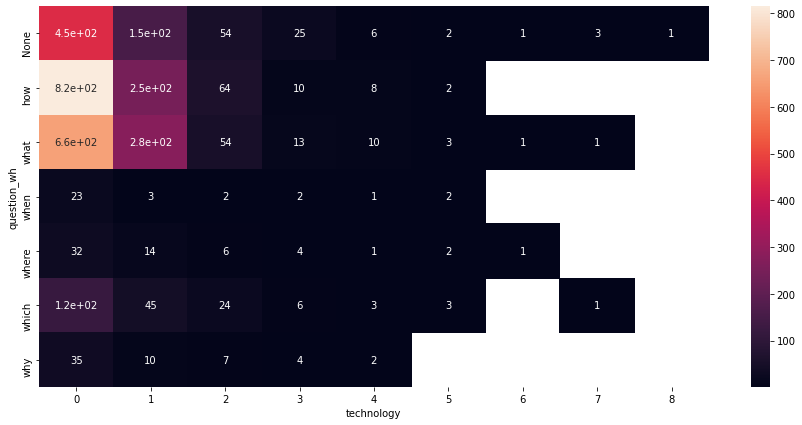

In [103]:
fig, ax = plt.subplots(figsize=[15, 7])
sns.heatmap(pd.crosstab(index=train_df['question_wh'], columns=train_df['technology'], values=train_df['technology'], aggfunc='count'), annot=True)

In [298]:
for q in train_df[train_df.question_wh == 'what'].sample(n=20).question:
    print(q)
    print('-'*100)

What should a web developer know in 2020?
----------------------------------------------------------------------------------------------------
What are the basic skills required to get an internship in web development?
----------------------------------------------------------------------------------------------------
What skill is required to develop Android apps?
----------------------------------------------------------------------------------------------------
What specific skills should an iOS developer learn to become appealing to a greater number of companies, is it Android, cross-platform, PWAs, backend language/framework, AWS, Azure?
----------------------------------------------------------------------------------------------------
What are the best books for Android application development?
----------------------------------------------------------------------------------------------------
Should I try to become a red hat architect or go into Data analysis after graduation i

In [108]:
from nltk import pos_tag

for q in train_df[train_df.question_wh == 'what'].sample(n=20).question:
    print(q)
    print('-'*100)

What level of competency in mathematics is required to become a web developer?
----------------------------------------------------------------------------------------------------
What are the qualities need to become a better front-end developer?
----------------------------------------------------------------------------------------------------
My friend says that the job of a web developer is going to be stagnant, in means of getting promotion, like becoming a team lead, and the other positions. I'm more into front end, though I also possess knowledge about PHP, SQL. I also have quite a knowledge about Java. What do I do?
----------------------------------------------------------------------------------------------------
Can I become a data analyst witha physics honours degree and no background in data analysis? What courses do I need to do? Where can I apply for jobs?
----------------------------------------------------------------------------------------------------
What are the c

In [104]:
pos_tag(word_tokenize('What is the fastest way to become a full-stack developer in 2019?'))

[('What', 'WP'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('fastest', 'JJS'),
 ('way', 'NN'),
 ('to', 'TO'),
 ('become', 'VB'),
 ('a', 'DT'),
 ('full-stack', 'JJ'),
 ('developer', 'NN'),
 ('in', 'IN'),
 ('2019', 'CD'),
 ('?', '.')]

In [106]:
wh_list = []
for q in train_df.question:
    selected_list = ['WRB', 'WP', 'WDT', 'WP$']
    tokens = pos_tag(word_tokenize(q))
    for word, tag in tokens:
        if tag in selected_list and word.lower() not in wh_list:
            wh_list.append(word.lower())
            
print(wh_list)

['how', 'what', 'who', 'when', 'where', 'which', 'that', 'why', '.what', 'years.what', 'wherever']


In [86]:
count = 0
for q in train_df.question:
    if 'Treehouse' in q:
        count = count + 1
        
count

1

### Entity extraction

In [3]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [4]:
word_list = []
entities = []
for q in train_df.question:
    doc = nlp(q)

    # Analyze syntax
    word_list.extend([chunk.text for chunk in doc.noun_chunks])
    #print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

    # Find named entities, phrases and concepts
    for entity in doc.ents:
        #print(entity.text, entity.label_)
        entities.append({
            'text': entity.text,
            'label': entity.label_
        })

In [82]:
word_list = [x.lower() for x in word_list]
counter = Counter(word_list)
word_frequents = pd.DataFrame(counter.items(), columns = ['text', 'fre'])
word_frequents.head()

,text,fre
0,i,705
1,a data scientist,356
2,college,6
3,a degree,9
4,what,187


In [83]:
word_frequents.sort_values(by=['fre'], ascending=False).head(10)

,text,fre
0,i,705
1,a data scientist,356
21,data science,188
4,what,187
30,it,132
186,a data engineer,78
12,you,75
6,a data analyst,52
156,data analysis,51
75,computer science,44


In [5]:
entity_df = pd.DataFrame(entities)
entity_df.head()

,text,label
0,HTML5,NORP
1,CSS,ORG
2,JavaScript,ORG
3,Bootstrap,PERSON
4,PHP,ORG


In [31]:
entity_df[entity_df.label == "PERSON"].sample(n=10)

,text,label
333,C++,PERSON
1943,my b. Tech,PERSON
1617,Raku,PERSON
373,Algorithms,PERSON
803,Java,PERSON
1611,Django,PERSON
1754,Django,PERSON
1632,Gmail,PERSON
250,Java,PERSON
1653,Adobe XD,PERSON


In [39]:
entity_df['label'].value_counts()

ORG            1184
DATE            420
PERSON          321
GPE             192
CARDINAL        129
NORP            105
ORDINAL          66
PRODUCT          56
WORK_OF_ART      41
TIME             25
LANGUAGE         20
FAC              14
LOC               5
PERCENT           4
MONEY             2
QUANTITY          2
EVENT             1
Name: label, dtype: int64

In [75]:
entity_df.loc[entity_df.label == 'ORG', 'text'].value_counts().head(20)

Android       384
CSS            74
PHP            47
JavaScript     42
CS             31
Data           26
Google         19
SQL            17
B.Tech         13
CSE            13
WordPress      12
MS             11
ML             11
jQuery         10
Microsoft       8
AI              8
UI/UX           7
TTS             7
Unity           7
Apple           7
Name: text, dtype: int64

In [85]:
entity_df['label'].value_counts()

ORG            264
DATE           105
GPE             55
WORK_OF_ART     35
CARDINAL        27
PERSON          26
ORDINAL         17
PRODUCT         15
NORP            11
TIME             3
PERCENT          2
LAW              2
LOC              2
EVENT            1
FAC              1
Name: label, dtype: int64

In [92]:
entity_df.sample(n=20)

,text,label
461,AI,ORG
565,Econometrician,NORP
502,an Applied Math:,WORK_OF_ART
41,MSc Computer Science,PRODUCT
538,two,CARDINAL
453,1 year,DATE
131,34612,CARDINAL
15,quora,PERSON
385,BCA,ORG
143,SQL,ORG


In [88]:
entity_df[entity_df.label == 'DATE'].sample(n=20)

,text,label
280,6 months,DATE
416,3 years,DATE
386,one year,DATE
254,the 2nd year,DATE
455,3-4 years,DATE
499,2020,DATE
389,34 year old,DATE
441,1st year,DATE
383,2024,DATE
529,more than 10 years,DATE
